In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from catboost import CatBoostClassifier

from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from imblearn.combine import SMOTETomek

!pip install lofo-importance
from lofo import LOFOImportance, Dataset, plot_importance

     |████████████████████████████████| 66.1MB 42kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.6/dist-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dfn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_test_combo_feature_engg.csv')
dfn1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_test_combo_feature_engg.csv')
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
train1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
test1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')

In [ ]:
#for big dataset with no dummies
dfn['Year'] = dfn['Vintage']/365
train_dfn = dfn.loc[dfn.flag.isin(['train'])]
test_dfn = dfn.loc[dfn.flag.isin(['test'])]
train_dfn.drop(columns={'flag'}, axis=1, inplace=True)
test_dfn.drop(columns={'flag', 'Response'}, axis=1, inplace=True)
train_dfn['Region_Code'] = train_dfn['Region_Code'].astype(int)
test_dfn['Region_Code'] = test_dfn['Region_Code'].astype(int)
train_dfn['Policy_Sales_Channel'] = train_dfn['Policy_Sales_Channel'].astype(int)
test_dfn['Policy_Sales_Channel'] = test_dfn['Policy_Sales_Channel'].astype(int)
train_dfn['Response'] = train_dfn['Response'].astype('int')

cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code']

#for big dataset with dummies
#train_dfn1['Region_Code'] = train_dfn1['Region_Code'].astype(int)
#test_dfn1['Region_Code'] = test_dfn1['Region_Code'].astype(int)
#train_dfn1['Policy_Sales_Channel'] = train_dfn1['Policy_Sales_Channel'].astype(int)
#test_dfn1['Policy_Sales_Channel'] = test_dfn1['Policy_Sales_Channel'].astype(int)
dfn1 = pd.get_dummies(dfn1, columns=cols, drop_first=False)
dfn1['Year'] = dfn1['Vintage']/365
train_dfn1 = dfn1.loc[dfn.flag.isin(['train'])]
test_dfn1 = dfn1.loc[dfn.flag.isin(['test'])]
train_dfn1.drop(columns={'flag'}, axis=1, inplace=True)
test_dfn1.drop(columns={'flag', 'Response'}, axis=1, inplace=True)
train_dfn1['Response'] = train_dfn1['Response'].astype('int')


#for small dataset with no dummies
train['Vehicle_Age'] = train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
train['Gender'] = train['Gender'].replace({'Male':1,'Female':0})
train['Vehicle_Damage'] = train['Vehicle_Damage'].replace({'Yes':1,'No':0})
test['Vehicle_Age'] = test['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
test['Gender'] = test['Gender'].replace({'Male':1,'Female':0})
test['Vehicle_Damage'] = test['Vehicle_Damage'].replace({'Yes':1,'No':0})
train['Year'] = train['Vintage']/365
test['Year'] = test['Vintage']/365

train['Region_Code'] = train['Region_Code'].astype(int)
test['Region_Code'] = test['Region_Code'].astype(int)
train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel'] = test['Policy_Sales_Channel'].astype(int)

#for small dataset with dummies
train1 = pd.get_dummies(train1, columns=cols, drop_first=False)
test1 = pd.get_dummies(test1, columns=cols, drop_first=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [3]:
col1 = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Year']

col2 = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'min_Annual_premium_by_region',
       'mean_Annual_premium_by_region', 'sum_Annual_premium_by_region',
       'max_Annual_premium_by_region', 'min_vintage_by_region',
       'mean_vintage_by_region', 'sum_vintage_by_region',
       'max_vintage_by_region', 'min_Age_by_region', 'mean_Age_by_region',
       'max_Age_by_region', 'min_Annual_premium_by_channel',
       'mean_Annual_premium_by_channel', 'sum_Annual_premium_by_channel',
       'max_Annual_premium_by_channel', 'count_insured_premium_by_region',
       'RANK_region', 'RANK_channel',
       'min_Annual_premium_by_channel_region',
       'mean_Annual_premium_by_channel_region',
       'sum_Annual_premium_by_channel_region',
       'max_Annual_premium_by_channel_region', 'count_channel_by_region']

col3 = ['Age', 'Driving_License', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'min_Annual_premium_by_region', 'mean_Annual_premium_by_region',
       'sum_Annual_premium_by_region', 'max_Annual_premium_by_region',
       'min_vintage_by_region', 'mean_vintage_by_region',
       'sum_vintage_by_region', 'max_vintage_by_region',
       'min_Age_by_region', 'mean_Age_by_region', 'max_Age_by_region',
       'min_Annual_premium_by_channel', 'mean_Annual_premium_by_channel',
       'sum_Annual_premium_by_channel', 'max_Annual_premium_by_channel',
       'count_insured_premium_by_region', 'RANK_region', 'RANK_channel',
       'min_Annual_premium_by_channel_region',
       'mean_Annual_premium_by_channel_region',
       'sum_Annual_premium_by_channel_region',
       'max_Annual_premium_by_channel_region', 'count_channel_by_region',
       'Gender_0', 'Gender_1', 'Vehicle_Age_0', 'Vehicle_Age_1',
       'Vehicle_Age_2', 'Vehicle_Damage_0', 'Vehicle_Damage_1',
       'Region_Code_0.0', 'Region_Code_1.0', 'Region_Code_2.0',
       'Region_Code_3.0', 'Region_Code_4.0', 'Region_Code_5.0',
       'Region_Code_6.0', 'Region_Code_7.0', 'Region_Code_8.0',
       'Region_Code_9.0', 'Region_Code_10.0', 'Region_Code_11.0',
       'Region_Code_12.0', 'Region_Code_13.0', 'Region_Code_14.0',
       'Region_Code_15.0', 'Region_Code_16.0', 'Region_Code_17.0',
       'Region_Code_18.0', 'Region_Code_19.0', 'Region_Code_20.0',
       'Region_Code_21.0', 'Region_Code_22.0', 'Region_Code_23.0',
       'Region_Code_24.0', 'Region_Code_25.0', 'Region_Code_26.0',
       'Region_Code_27.0', 'Region_Code_28.0', 'Region_Code_29.0',
       'Region_Code_30.0', 'Region_Code_31.0', 'Region_Code_32.0',
       'Region_Code_33.0', 'Region_Code_34.0', 'Region_Code_35.0',
       'Region_Code_36.0', 'Region_Code_37.0', 'Region_Code_38.0',
       'Region_Code_39.0', 'Region_Code_40.0', 'Region_Code_41.0',
       'Region_Code_42.0', 'Region_Code_43.0', 'Region_Code_44.0',
       'Region_Code_45.0', 'Region_Code_46.0', 'Region_Code_47.0',
       'Region_Code_48.0', 'Region_Code_49.0', 'Region_Code_50.0',
       'Region_Code_51.0', 'Region_Code_52.0', 'Year']

col4 = ['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Gender_Female',
       'Gender_Male', 'Vehicle_Age_1-2 Year', 'Vehicle_Age_< 1 Year',
       'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes',
       'Region_Code_0.0', 'Region_Code_1.0', 'Region_Code_2.0',
       'Region_Code_3.0', 'Region_Code_4.0', 'Region_Code_5.0',
       'Region_Code_6.0', 'Region_Code_7.0', 'Region_Code_8.0',
       'Region_Code_9.0', 'Region_Code_10.0', 'Region_Code_11.0',
       'Region_Code_12.0', 'Region_Code_13.0', 'Region_Code_14.0',
       'Region_Code_15.0', 'Region_Code_16.0', 'Region_Code_17.0',
       'Region_Code_18.0', 'Region_Code_19.0', 'Region_Code_20.0',
       'Region_Code_21.0', 'Region_Code_22.0', 'Region_Code_23.0',
       'Region_Code_24.0', 'Region_Code_25.0', 'Region_Code_26.0',
       'Region_Code_27.0', 'Region_Code_28.0', 'Region_Code_29.0',
       'Region_Code_30.0', 'Region_Code_31.0', 'Region_Code_32.0',
       'Region_Code_33.0', 'Region_Code_34.0', 'Region_Code_35.0',
       'Region_Code_36.0', 'Region_Code_37.0', 'Region_Code_38.0',
       'Region_Code_39.0', 'Region_Code_40.0', 'Region_Code_41.0',
       'Region_Code_42.0', 'Region_Code_43.0', 'Region_Code_44.0',
       'Region_Code_45.0', 'Region_Code_46.0', 'Region_Code_47.0',
       'Region_Code_48.0', 'Region_Code_49.0', 'Region_Code_50.0',
       'Region_Code_51.0', 'Region_Code_52.0']

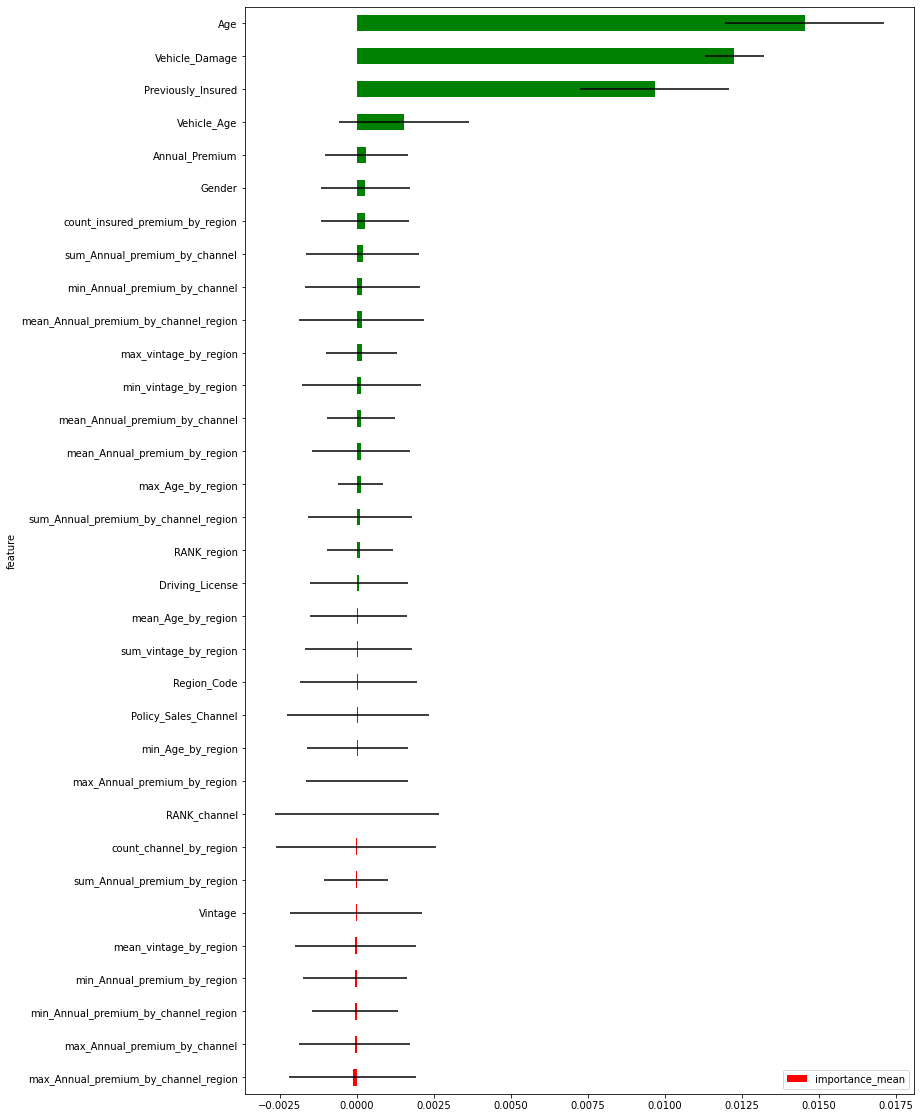

In [7]:
dataset = Dataset(train2, target="Response", features=col2)
cv = KFold(n_splits=5, shuffle=True)
lof = LOFOImportance(dataset = dataset, scoring='roc_auc', cv=cv)
importance_df = lof.get_importance()
plot_importance(importance_df, figsize=(12, 20))

In [4]:
train2, test2 = dfn[dfn.flag=='train'], dfn[dfn.flag=='test']

In [25]:
col_imp = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'min_Annual_premium_by_region',
       'mean_Annual_premium_by_region', 'sum_Annual_premium_by_region',
       'max_Annual_premium_by_region', 'sum_vintage_by_region',
       'max_vintage_by_region', 'min_Age_by_region', 'mean_Age_by_region',
       'max_Age_by_region', 'min_Annual_premium_by_channel',
       'mean_Annual_premium_by_channel', 'sum_Annual_premium_by_channel',
      'count_insured_premium_by_region',
       'RANK_region', 'RANK_channel']

In [26]:
X = train2[col_imp]
y = train2['Response']
m = CatBoostClassifier(random_seed=2011918)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=150303, stratify=y, shuffle=True, test_size=0.10)
m = m.fit(X_train, y_train, cat_features=cat_col1, eval_set=(X_test, y_test), plot=True, verbose=100, early_stopping_rounds=30)
y_cat = m.predict(X_test)
probs_cat_train = m.predict_proba(X_train)[:, 1]
probs_cat_test = m.predict_proba(X_test)[:, 1]
roc_auc_score(y_train, probs_cat_train)
roc_auc_score(y_test, probs_cat_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.134007
0:	learn: 0.4854020	test: 0.4845103	best: 0.4845103 (0)	total: 376ms	remaining: 6m 16s
100:	learn: 0.2625824	test: 0.2631649	best: 0.2631478 (88)	total: 29.9s	remaining: 4m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2629421617
bestIteration = 156

Shrink model to first 157 iterations.


0.8604918083584042

In [23]:
4555555555fgh5def log_loss(m, X, y): 
    return metrics.roc_auc_score(y,m.predict_proba(X)[:,1])

def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostClassifier()
    model.fit(X, y, cat_features = cat_col1, verbose = False)
    baseline = metric(model, X_test, y_test)
    
    imp = []
    for col in X.columns:
        
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features = cat_col1, verbose = False)
        m = metric(model, X_test, y_test)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(m, X_test, y_test, roc_auc_score)
    
    elif method == "Baseline":
        fi = baseline_importance(m, X_train, y_train, X_test, y_test, log_loss) 
        
    else:
        fi = m.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

In [24]:
%time get_feature_imp_plot(method="Permutation")

ValueError: ignored

In [16]:
from sklearn import metrics

In [45]:
#grid search
vals = {'depth':[6,7,8,10],
        'learning_rate':[0.13,0.12,0.134007,0.125,0.12806]}
gg = GridSearchCV(m, param_grid=vals, scoring='roc_auc', cv=5, verbose=50)
gg.fit(X_train, y_train)
print(gg.best_score_)
print(gg.best_params_)

Streaming output truncated to the last 5000 lines.
11:	learn: 0.2703531	total: 2.04s	remaining: 2m 47s
12:	learn: 0.2694115	total: 2.2s	remaining: 2m 47s
13:	learn: 0.2685794	total: 2.37s	remaining: 2m 46s
14:	learn: 0.2676341	total: 2.53s	remaining: 2m 46s
15:	learn: 0.2670259	total: 2.7s	remaining: 2m 45s
16:	learn: 0.2667190	total: 2.87s	remaining: 2m 45s
17:	learn: 0.2660872	total: 3.04s	remaining: 2m 45s
18:	learn: 0.2656047	total: 3.21s	remaining: 2m 45s
19:	learn: 0.2650582	total: 3.38s	remaining: 2m 45s
20:	learn: 0.2647093	total: 3.57s	remaining: 2m 46s
21:	learn: 0.2642487	total: 3.73s	remaining: 2m 46s
22:	learn: 0.2641000	total: 3.91s	remaining: 2m 46s
23:	learn: 0.2639113	total: 4.08s	remaining: 2m 45s
24:	learn: 0.2636272	total: 4.25s	remaining: 2m 45s
25:	learn: 0.2634418	total: 4.41s	remaining: 2m 45s
26:	learn: 0.2632233	total: 4.58s	remaining: 2m 45s
27:	learn: 0.2629706	total: 4.75s	remaining: 2m 44s
28:	learn: 0.2627923	total: 4.93s	remaining: 2m 45s
29:	learn: 0.26

In [40]:
preds = m.predict_proba(test2[col_imp])[:,1]
sub = pd.DataFrame({'id':test1.id, 'Response':preds})
sub.to_csv('/content/drive/My Drive/Colab Notebooks/lofo_try4_def.csv', index=False)

In [11]:
cat_col=['Driving_License', 'Previously_Insured', 'Policy_Sales_Channel']
cat_col1 =['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']

In [30]:
test2.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'flag',
       'min_Annual_premium_by_region', 'mean_Annual_premium_by_region',
       'sum_Annual_premium_by_region', 'max_Annual_premium_by_region',
       'min_vintage_by_region', 'mean_vintage_by_region',
       'sum_vintage_by_region', 'max_vintage_by_region', 'min_Age_by_region',
       'mean_Age_by_region', 'max_Age_by_region',
       'min_Annual_premium_by_channel', 'mean_Annual_premium_by_channel',
       'sum_Annual_premium_by_channel', 'max_Annual_premium_by_channel',
       'count_insured_premium_by_region', 'RANK_region', 'RANK_channel',
       'min_Annual_premium_by_channel_region',
       'mean_Annual_premium_by_channel_region',
       'sum_Annual_premium_by_channel_region',
       'max_Annual_premium_by_channel_region', 'count_channel_by_region'],
      dtype='object')

In [5]:
train2['Region_Code'] = train2['Region_Code'].astype(int)
test2['Region_Code'] = test2['Region_Code'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
train2.dtypes

id                                         int64
Gender                                     int64
Age                                        int64
Driving_License                            int64
Region_Code                              float64
Previously_Insured                         int64
Vehicle_Age                                int64
Vehicle_Damage                             int64
Annual_Premium                           float64
Policy_Sales_Channel                       int64
Vintage                                    int64
Response                                 float64
flag                                      object
min_Annual_premium_by_region             float64
mean_Annual_premium_by_region            float64
sum_Annual_premium_by_region             float64
max_Annual_premium_by_region             float64
min_vintage_by_region                      int64
mean_vintage_by_region                   float64
sum_vintage_by_region                      int64
max_vintage_by_regio

In [16]:
y.shape

(381109,)

In [ ]:
train2.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1       1   44                1         28.0                   0   
1   2       1   76                1          3.0                   0   
2   3       1   47                1         28.0                   0   
3   4       1   21                1         11.0                   1   
4   5       0   29                1         41.0                   1   

   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0            2               1         40454.0                  26.0      217   
1            1               0         33536.0                  26.0      183   
2            2               1         38294.0                  26.0       27   
3            0               0         28619.0                 152.0      203   
4            0               0         27496.0                 152.0       39   

   Response   flag  min_Annual_premium_by_region  \
0       1.0  train                        2630.0   
1       0.0  train                        2630.0   
2       1.0  train                        2630.0   
3       0.0  train                        2630.0   
4       0.0  train                        2630.0   

   mean_Annual_premium_by_region  sum_Annual_premium_by_region  \
0                   38649.878763                  5.485848e+09   
1                   24465.445218                  3.021238e+08   
2                   38649.878763                  5.485848e+09   
3                   27655.183160                  3.409331e+08   
4                   30948.979918                  7.551551e+08   

   max_Annual_premium_by_region  min_vintage_by_region  \
0                      540165.0                     10   
1                      424578.0                     10   
2                      540165.0                     10   
3                      193637.0                     10   
4                      339396.0                     10   

   mean_vintage_by_region  sum_vintage_by_region  max_vintage_by_region  \
0              154.266618               21896141                    299   
1              154.864442                1912421                    299   
2              154.266618               21896141                    299   
3              154.520360                1904927                    299   
4              154.851189                3778369                    299   

   min_Age_by_region  mean_Age_by_region  max_Age_by_region  \
0                 20           46.223536           540165.0   
1                 20           36.980970           424578.0   
2                 20           46.223536           540165.0   
3                 20           34.235480           193637.0   
4                 20           36.404016           339396.0   

   min_Annual_premium_by_channel  mean_Annual_premium_by_channel  \
0                         2630.0                    33639.830863   
1                         2630.0                    33639.830863   
2                         2630.0                    33639.830863   
3                         2630.0                    30898.685511   
4                         2630.0                    30898.685511   

   sum_Annual_premium_by_channel  max_Annual_premium_by_channel  \
0                   3.585804e+09                       540165.0   
1                   3.585804e+09                       540165.0   
2                   3.585804e+09                       540165.0   
3                   5.547025e+09                       495106.0   
4                   5.547025e+09                       495106.0   

   count_insured_premium_by_region  RANK_region  RANK_channel  \
0                            44166          1.0           1.0   
1                             6000          1.0           1.0   
2                            44166          1.0           1.0   
3                             7662          1.0           1.0   
4                            13820          1.0          

In [ ]:
dfn.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1       1   44                1         28.0                   0   
1   2       1   76                1          3.0                   0   
2   3       1   47                1         28.0                   0   
3   4       1   21                1         11.0                   1   
4   5       0   29                1         41.0                   1   

   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0            2               1         40454.0                  26.0      217   
1            1               0         33536.0                  26.0      183   
2            2               1         38294.0                  26.0       27   
3            0               0         28619.0                 152.0      203   
4            0               0         27496.0                 152.0       39   

   Response   flag  min_Annual_premium_by_region  \
0       1.0  train                        2630.0   
1       0.0  train                        2630.0   
2       1.0  train                        2630.0   
3       0.0  train                        2630.0   
4       0.0  train                        2630.0   

   mean_Annual_premium_by_region  sum_Annual_premium_by_region  \
0                   38649.878763                  5.485848e+09   
1                   24465.445218                  3.021238e+08   
2                   38649.878763                  5.485848e+09   
3                   27655.183160                  3.409331e+08   
4                   30948.979918                  7.551551e+08   

   max_Annual_premium_by_region  min_vintage_by_region  \
0                      540165.0                     10   
1                      424578.0                     10   
2                      540165.0                     10   
3                      193637.0                     10   
4                      339396.0                     10   

   mean_vintage_by_region  sum_vintage_by_region  max_vintage_by_region  \
0              154.266618               21896141                    299   
1              154.864442                1912421                    299   
2              154.266618               21896141                    299   
3              154.520360                1904927                    299   
4              154.851189                3778369                    299   

   min_Age_by_region  mean_Age_by_region  max_Age_by_region  \
0                 20           46.223536           540165.0   
1                 20           36.980970           424578.0   
2                 20           46.223536           540165.0   
3                 20           34.235480           193637.0   
4                 20           36.404016           339396.0   

   min_Annual_premium_by_channel  mean_Annual_premium_by_channel  \
0                         2630.0                    33639.830863   
1                         2630.0                    33639.830863   
2                         2630.0                    33639.830863   
3                         2630.0                    30898.685511   
4                         2630.0                    30898.685511   

   sum_Annual_premium_by_channel  max_Annual_premium_by_channel  \
0                   3.585804e+09                       540165.0   
1                   3.585804e+09                       540165.0   
2                   3.585804e+09                       540165.0   
3                   5.547025e+09                       495106.0   
4                   5.547025e+09                       495106.0   

   count_insured_premium_by_region  RANK_region  RANK_channel  \
0                            44166          1.0           1.0   
1                             6000          1.0           1.0   
2                            44166          1.0           1.0   
3                             7662          1.0           1.0   
4                            13820          1.0          

## **Catboost**

train_test_split

In [6]:
train2['Policy_Sales_Channel'] = train2['Policy_Sales_Channel'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
test2['Policy_Sales_Channel'] = test2['Policy_Sales_Channel'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#for small dataset with no dummies
X = train[col1]
y = train['Response']
X_t, X_tt, y_t, y_tt = train_test_split(X, y, test_size=.25, random_state=150303, stratify=y, shuffle=True)

#for small dataset with dummies
X1 = train1[col4]
y1 = train1['Response']
X_t1, X_tt1, y_t1, y_tt1 = train_test_split(X1, y1, test_size=0.15, random_state=1503030,stratify=y1,shuffle=True)

In [ ]:
from sklearn.metrics import auc

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.128106
0:	learn: 0.4927357	test: 0.4931191	best: 0.4931191 (0)	total: 380ms	remaining: 6m 19s
100:	learn: 0.2631881	test: 0.2646420	best: 0.2646420 (100)	total: 29.4s	remaining: 4m 21s
200:	learn: 0.2614709	test: 0.2644493	best: 0.2644353 (198)	total: 1m	remaining: 3m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2644353301
bestIteration = 198

Shrink model to first 199 iterations.


AttributeError: ignored

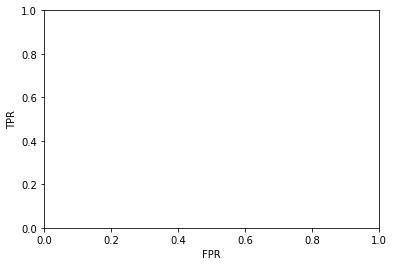

In [ ]:
#for small dataset with no dummmies
cat = CatBoostClassifier()
cat= cat.fit(X_t, y_t, cat_features=cat_col1, eval_set=(X_tt, y_tt), plot=True, early_stopping_rounds=30, verbose=100)
y_cat = cat.predict(X_tt)
probs_cat_train = cat.predict_proba(X_t)[:, 1]
probs_cat_test = cat.predict_proba(X_tt)[:, 1]
roc_auc_score(y_t, probs_cat_train)
roc_auc_score(y_tt, probs_cat_test)
fpr, tpr, thresholds = roc_curve(y_tt, probs_cat_test)
roc_auc_cat = auc(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, lw=3, label='area', =roc_auc_cat)
plt.plot([0,1], [0,1], color='orange', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()
#custom_metric(cat, X_t, y_t)
#custom_metric(cat, X_tt, y_tt)

In [ ]:
#for small dataset with dummies
catb = CatBoostClassifier(use_best_model=True, depth=11, l2_leaf_reg=6)
catb= catb.fit(X_t1, y_t1, cat_features=cat_col, eval_set=(X_tt1, y_tt1), plot=True, early_stopping_rounds=50, verbose=100)
y_cat = catb.predict(X_tt1)
probs_cat_train = catb.predict_proba(X_t1)[:, 1]
probs_cat_test = catb.predict_proba(X_tt1)[:, 1]
custom_metric(catb, X_t1, y_t1)
custom_metric(catb, X_tt1, y_tt1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6355044	test: 0.6355223	best: 0.6355223 (0)	total: 246ms	remaining: 4m 5s
100:	learn: 0.2651186	test: 0.2665065	best: 0.2665065 (100)	total: 40s	remaining: 5m 56s
200:	learn: 0.2612417	test: 0.2646790	best: 0.2646790 (200)	total: 1m 28s	remaining: 5m 50s
300:	learn: 0.2590653	test: 0.2643635	best: 0.2643635 (300)	total: 2m 15s	remaining: 5m 14s
400:	learn: 0.2571791	test: 0.2643048	best: 0.2642967 (395)	total: 3m 4s	remaining: 4m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2642967354
bestIteration = 395

Shrink model to first 396 iterations.
87.85214637188139
87.74642713453565


In [ ]:
catb_pred = catb.predict_proba(test1[col4])[:, 1]
submission = pd.DataFrame({'id':test1.id})
submission['Response'] = catb_pred
submission.to_csv('/content/drive/My Drive/Colab Notebooks/cat_dum_lr13d14.csv', index=False)

In [ ]:
from sklearn import neighbors

In [ ]:
adasyn(X, y, 0.001, 10, 1)

TypeError: ignored

In [ ]:
cat_pred2 = cat.predict_proba(test[col1])[:, 1]
submission = pd.DataFrame({'id':test1.id})
submission['Response'] = cat_pred2
submission.to_csv('/content/drive/My Drive/Colab Notebooks/cat_defdiff.csv', index=False)

In [ ]:
#for small dataset with dummies
catb1 = CatBoostClassifier(depth=10, l2_leaf_reg=4)
catb1 = catb1.fit(X_t, y_t, cat_features=cat_col1, eval_set=(X_tt, y_tt), plot=True, early_stopping_rounds=30, verbose=100)
y_cat = catb1.predict(X_tt)
probs_cat_train = catb1.predict_proba(X_t)[:, 1]
probs_cat_test = catb1.predict_proba(X_tt)[:, 1]
roc_auc_score(y_t, probs_cat_train)
roc_auc_score(y_tt, probs_cat_test)
custom_metric(catb1, X_t, y_t)
custom_metric(catb1, X_tt, y_tt)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6358443	test: 0.6359561	best: 0.6359561 (0)	total: 522ms	remaining: 8m 41s
100:	learn: 0.2643180	test: 0.2656473	best: 0.2656473 (100)	total: 45.8s	remaining: 6m 48s
200:	learn: 0.2611304	test: 0.2644186	best: 0.2644186 (200)	total: 1m 32s	remaining: 6m 9s
300:	learn: 0.2590198	test: 0.2642268	best: 0.2642181 (297)	total: 2m 21s	remaining: 5m 27s
400:	learn: 0.2575256	test: 0.2641786	best: 0.2641706 (393)	total: 3m 5s	remaining: 4m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2641706346
bestIteration = 393

Shrink model to first 394 iterations.
87.85366177916322
87.75268162639854


In [ ]:
catb_pred1 = catb1.predict_proba(test[col1])[:, 1]
submission = pd.DataFrame({'id':test1.id})
submission['Response'] = catb_pred1
submission.to_csv('/content/drive/My Drive/Colab Notebooks/cat_d10l23.csv', index=False)

In [ ]:
def custom_metric(model, p, q):
  pred = model.predict_proba(p)[:,1]
  pred_round = np.round(pred)
  for i in range(len(pred_round)):
    if pred_round[i] >= 0.5:
      pred_round[i] = 1
    else:
      pred_round[i] = 0
  l = len(q)
  n = abs(pred_round - q)
  z = np.count_nonzero(n)
  print(100 - ((z*100)/l))

In [ ]:
def adasyn(X, y, beta, K, threshold=1):
  ms = int(sum(y))
  ml = len(y) - ms

  clf = neighbors.KNeighborsClassifier()
  clf.fit(X, y)

  # Step 1, calculate the degree of class imbalance.  If degree of class imbalance is violated, continue.
  d = np.divide(ms, ml)

  if d > threshold:
      return print("The data set is not imbalanced enough.")

  # Step 2a, if the minority data set is below the maximum tolerated threshold, generate data.
  # Beta is the desired balance level parameter.  Beta > 1 means u want more of the imbalanced type, vice versa.
  G = (ml - ms) * beta

  # Step 2b, find the K nearest neighbours of each minority class example in euclidean distance.
  # Find the ratio ri = majority_class in neighbourhood / K
  Ri = []
  Minority_per_xi = []
  for i in range(ms):
      xi = X[i, :].reshape(1, -1)
      # Returns indices of the closest neighbours, and return it as a list
      neighbours = clf.kneighbors(xi, n_neighbors=K, return_distance=False)[0]
      # Skip classifying itself as one of its own neighbours
      # neighbours = neighbours[1:]

      # Count how many belongs to the majority class
      count = 0
      for value in neighbours:
          if value > ms:
              count += 1

      Ri.append(count / K)

      # Find all the minority examples
      minority = []
      for value in neighbours:
          # Shifted back 1 because indices start at 0
          if value <= ms - 1:
              minority.append(value)

      Minority_per_xi.append(minority)

  # Step 2c, normalize ri's so their sum equals to 1
  Rhat_i = []
  for ri in Ri:
      rhat_i = ri / sum(Ri)
      Rhat_i.append(rhat_i)

  assert(sum(Rhat_i) > 0.99)

  # Step 2d, calculate the number of synthetic data examples that will be generated for each minority example
  Gi = []
  for rhat_i in Rhat_i:
      gi = round(rhat_i * G)
      Gi.append(int(gi))

  # # Step 2e, generate synthetic examples
  syn_data = []
  for i in range(ms):
      xi = X[i, :].reshape(1, -1)
      for j in range(Gi[i]):
          # If the minority list is not empty
          if Minority_per_xi[i]:
              index = np.random.choice(Minority_per_xi[i])
              xzi = X[index, :].reshape(1, -1)
              si = xi + (xzi - xi) * np.random.uniform(0, 1)
              syn_data.append(si)

  # Test the new generated data
  test = []
  for values in syn_data:
      a = clf.predict(values)
      test.append(a)

  print("Using the old classifier, {} out of {} would be classified as minority.".format(np.sum(test), len(syn_data)))

  # Build the data matrix
  data = []
  for values in syn_data:
      data.append(values[0])

  print("{} amount of minority class samples generated".format(len(data)))

  # Concatenate the positive labels with the newly made data
  labels = np.ones([len(data), 1])
  data = np.concatenate([labels, data], axis=1)

  # Concatenate with old data
  org_data = np.concatenate([y.reshape(-1, 1), X], axis=1)
  data = np.concatenate([data, org_data])

  return data, Minority_per_xi, Ri


In [ ]:
len(X)

381109

In [ ]:
y.sum()

46710

In [ ]:
(381109-46710)/46710

7.15904517233997

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
target = train['Response']

In [ ]:
target=train['Response']
train=train.drop(['Response','id'],axis=1)
a={'Male':0,'Female':1}
train['Gender']=train['Gender'].map(a)
a={'> 2 Years':0, '1-2 Year':2, '< 1 Year':1}
train['Vehicle_Age']=train['Vehicle_Age'].map(a)
a={'Yes':1,'No':0}
train['Vehicle_Damage']=train['Vehicle_Damage'].map(a)



a={'Male':0,'Female':1}
test['Gender']=test['Gender'].map(a)
a={'> 2 Years':0, '1-2 Year':2, '< 1 Year':1}
test['Vehicle_Age']=test['Vehicle_Age'].map(a)
a={'Yes':1,'No':0}
test['Vehicle_Damage']=test['Vehicle_Damage'].map(a)

ids=test['id']
test=test.drop(['id'],axis=1)

In [ ]:
os=SMOTETomek(0.75)
X_train_ns,y_train_ns=os.fit_sample(train,target)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_train_ns,y_train_ns,test_size=0.4,random_state=3)

In [ ]:
cols=['Previously_Insured','Vintage','Age','Vehicle_Damage','Annual_Premium','Policy_Sales_Channel','Region_Code','Gender','Vehicle_Age']
#X_train=X_train[cols]
rfc1=RandomForestClassifier()
rfc1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=rfc1.predict_proba(X_test)

#print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

ValueError: ignored

In [ ]:
roc_auc_score(y_test,y_pred)

0.8984159936529493

In [ ]:
rfc_st = pd.DataFrame({'id':test1.id, 'Response':rfc1.predict_proba(test)})
rfc_st.to_csv('/content/drive/My Drive/Colab Notebooks/rfc_st1.csv', index=False)

Exception: ignored

In [ ]:
%%time
err = [] 
y_pred_tot_lgm = np.zeros((len(test), 2))


fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = CatBoostClassifier(n_estimators=10000,
                       random_state=150303,
                       eval_metric='AUC',
                       #learning_rate=0.08,
                       #depth=8,
                       #bagging_temperature=0.3,
                       task_type='GPU'
                       #num_leaves=64
                       
                       )
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=100,verbose=200)
    pred_y = m.predict(x_val)
    print(i, " err_lgm: ", accuracy_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    y_pred_tot_lgm+= m.predict_proba(test)
    i = i + 1
y_pred_tot_lgm=y_pred_tot_lgm/10
sum(err)/10

Learning rate set to 0.016712
0:	learn: 0.8354769	test: 0.8369606	best: 0.8369606 (0)	total: 32.6ms	remaining: 5m 26s
200:	learn: 0.8550456	test: 0.8556094	best: 0.8556094 (200)	total: 5.43s	remaining: 4m 24s
400:	learn: 0.8574106	test: 0.8576806	best: 0.8576823 (399)	total: 10.7s	remaining: 4m 15s
600:	learn: 0.8587857	test: 0.8585235	best: 0.8585265 (599)	total: 15.8s	remaining: 4m 7s
800:	learn: 0.8598827	test: 0.8590192	best: 0.8590204 (796)	total: 21s	remaining: 4m
1000:	learn: 0.8609267	test: 0.8592199	best: 0.8592199 (1000)	total: 26.1s	remaining: 3m 55s
1200:	learn: 0.8617555	test: 0.8594170	best: 0.8594170 (1200)	total: 31.3s	remaining: 3m 49s
1400:	learn: 0.8624884	test: 0.8594803	best: 0.8594857 (1396)	total: 36.6s	remaining: 3m 44s
1600:	learn: 0.8632098	test: 0.8595561	best: 0.8595561 (1600)	total: 41.9s	remaining: 3m 39s
1800:	learn: 0.8638664	test: 0.8595778	best: 0.8595881 (1774)	total: 47s	remaining: 3m 33s
2000:	learn: 0.8645008	test: 0.8596304	best: 0.8596340 (1949)	

In [ ]:
x=train1.drop(columns={'id','Response'},axis=1)
y=train1.loc[:,['Response']]
test1=test1.drop(columns={'id'},axis=1)

KeyError: ignored

In [ ]:
train1["Gender"].replace({"Male":0, "Female":1}, inplace=True)

test1["Gender"].replace({"Male":0, "Female":1}, inplace=True)
train1["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year":1, "> 2 Years":3}, inplace=True)

test1["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year":1, "> 2 Years":3}, inplace=True)
train1["Vehicle_Damage"].replace({"Yes": 0, "No":1}, inplace=True)

test1["Vehicle_Damage"].replace({"Yes": 0, "No":1}, inplace=True)